In [425]:
import numpy as np
import pandas as pd
import math

## Load the .csv data

In [426]:
train_data_path = "train.csv"
test_data_path = "test.csv"
raw_data = pd.read_csv(train_data_path, encoding="big5")
raw_test_data = pd.read_csv(test_data_path, encoding="big5", header=None)
raw_data[raw_data == "NR"] = 0
raw_test_data[raw_test_data == "NR"] = 0

## Explore the data

In [427]:
raw_test_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,id_0,AMB_TEMP,21,21,20,20,19,19,19,18,17
1,id_0,CH4,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.8
2,id_0,CO,0.39,0.36,0.36,0.4,0.53,0.55,0.34,0.31,0.23
3,id_0,NMHC,0.16,0.24,0.22,0.27,0.27,0.26,0.27,0.29,0.1
4,id_0,NO,1.3,1.3,1.3,1.3,1.4,1.6,1.2,1.1,0.9


## Data Preprocessing (1)

Concatenate all the hour-wise data of each month.

Now there are 12 months in the dict "month_data", each is a 18*480 numpy.

In [428]:
zdata = raw_data.iloc[:, 3:].to_numpy()
month_data = {} # 12 months (0~11), 20 days per month => 480 hours per month
for month in range(12):
    cur_month_data = np.empty([18, 480])
    for day in range(20):
        cur_month_data[:, day*24: (day + 1) * 24] = data[(month * 20 + day) * 18: (month * 20 + day + 1) * 18, :]
    month_data[month] = cur_month_data

## Data Preprocessing (2)

Extract every adjacent 10 hours. 12*471=5652 pieces of data can be extracted.

For each piece of data, there are 18*9 features and one target (PM2.5).

Shapes: 

- X: 5652*162
- y: 5652

In [429]:
X = np.empty([12*471, 18*9])
y = np.empty([12*471])
for month in range(12):
    for hour in range(471):
        X[month * 471 + hour] = month_data[month][:, hour: hour + 9].flatten()
        y[month * 471 + hour] = month_data[month][9, hour + 9]

## Normalization

Compute mean and std of X, and then normalize X

In [430]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean)/std

## Shuffle And Split

Shuffle X and y simultaneously. 

Split X into train_X and val_X, y into train_y and val_y

In [431]:
perm = np.random.permutation(X.shape[0])
shuffled_X = X[perm, :]
shuffled_y = y[perm]
train_size = math.floor(0.8 * X.shape[0])
train_X = shuffled_X[:train_size, :]
val_X = shuffled_X[train_size:, :]
train_y = shuffled_y[:train_size]
val_y = shuffled_y[train_size:]

## Training

Train a linear regression model using train_X

In [432]:
train_loss = []
val_loss = []
def calc_loss(model, X, y):
    pred = model.predict(X)
    return np.inner(pred - y, pred - y) / (2 * X.shape[0])
class LinearRegressor:
    def predict(self, X):
        X = np.hstack((np.ones([X.shape[0], 1]), X)) # 左侧补一列常数 feature 1
        return np.squeeze(np.dot(X, self.theta))
    def train(self, X, y, iters=2000, lr=0.03):
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        self.theta = np.random.normal(0, 1, (X.shape[1], 1))
        for i in range(iters):
            pred = np.squeeze(np.dot(X, self.theta))
            grad = np.dot(X.T, np.expand_dims(pred - y, 1)) / X.shape[0]
            self.theta -= lr * grad
            train_loss.append(calc_loss(self, train_X, train_y))
            val_loss.append(calc_loss(self, val_X, val_y))
model = LinearRegressor()
model.train(train_X, train_y)


# Plot the loss curve

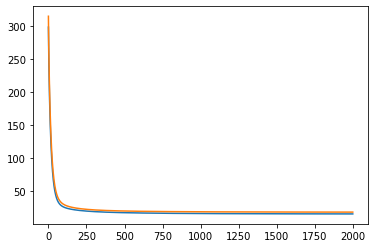

Last val_loss: 18.68205505614183


In [433]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(val_loss)), val_loss)
plt.show()
print("Last val_loss: {}".format(val_loss[-1]))

## Preprocess the test data

1. Convert test_data into n*162 numpy
2. normalize

In [434]:
test_X = raw_test_data.iloc[:, 2:].to_numpy().reshape(-1, 162).astype(float) 
test_X = (test_X - mean) / std

In [435]:
final_model = LinearRegressor()
final_model.train(X, y)
test_pred = final_model.predict(test_X)

In [436]:
test_pred_list = [("id_{}".format(i), test_pred[i]) for i in range(test_X.shape[0])]
test_pred_df = pd.DataFrame(test_pred_list)
test_pred_df

,0,1
0,id_0,5.123752
1,id_1,17.680060
2,id_2,24.164032
3,id_3,7.994766
4,id_4,27.336055
...,...,...
235,id_235,41.559261
236,id_236,68.630544
237,id_237,40.456429
238,id_238,12.548534


In [437]:
output_path = "submit.csv"
test_pred_df.to_csv(output_path, header=["id", "value"], index=False)